In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#from sklearn import tree
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import graphviz
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
import seaborn as sns
import re
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import StratifiedShuffleSplit,KFold,StratifiedKFold
from imblearn.over_sampling import SMOTE,SVMSMOTE
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier,RUSBoostClassifier,EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from source_data import SourceData
from PreProcessing import PreProcessing
from Dimensionalty_Reduction import Dimensional_Reduction
from Data_Modelling import DataModelling
from Eval_Metrics import EvalMetrics


In [3]:
pd.set_option('mode.chained_assignment',None)

In [4]:
pp=PreProcessing()
dr=Dimensional_Reduction()
dm=DataModelling()
em=EvalMetrics()

In [5]:
qualitative_data=pp.readcsv("2020-06-10_all-qual-mph-data.csv")
admisn_data_2017=pp.readcsv("Admissions-Data-LP-2017.csv")
admisn_data_2018=pp.readcsv("Admissions-Data-LP-2018.csv")
admisn_data_2019=pp.readcsv("SP19 and FA19 Data file.csv")
qual_data=pp.readcsv('2020-07-15_aggregated-data.csv')
new_data=pp.readcsv('Admissions-Data-for-LP.csv')

C:\Users\pavan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (1758,1759,1977,1978,2047,2048,2104,2159) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
pp.add_year(admisn_data_2017,2017)
pp.add_year(admisn_data_2018,2018)
pp.add_year(admisn_data_2019,2019)
pp.add_year(new_data,2020)

In [7]:
data_list=[admisn_data_2017,admisn_data_2018,admisn_data_2019]
nd_list=[admisn_data_2017,admisn_data_2018,admisn_data_2019,new_data]

In [8]:
common_cols=pp.get_common_cols(nd_list)
common_data=pp.get_common_data(data_list,common_cols)
nd_data=pp.get_common_data([new_data],common_cols)

In [9]:
common_data.shape

(568, 561)

In [10]:
nd_data.shape

(138, 561)

In [11]:
## NULL Check in the first column of target label
common_data=pp.check_null_col(common_data,"decision_code")
nd_data=pp.check_null_col(nd_data,"decision_code") 

In [12]:
## Group Target Labels

admitted_list=['Matriculated','Declined','Deferred','Admission Offered - awaiting applicant response',
         'Declined Offer - applicant declined admission offer from program']
incomplete_list=['Incomplete Application','Not Considered - application not considered']
denied_list=['Denied - applicant denied admission','Denied/Rejected - applicant denied admission by program']


## Calling the function
pp.target_label(common_data,admitted_list,incomplete_list,denied_list)
pp.target_label(nd_data,admitted_list,incomplete_list,denied_list)

In [13]:
common_data.decision_code_0.unique()

array(['Admitted', 'Denied', 'Incomplete'], dtype=object)

In [14]:
def rem_incomplete(final_data):
    final_data=final_data.drop(final_data[final_data.decision_code_0=='Incomplete'].index).reset_index()
    category=['Denied','Admitted']
    cat_type = CategoricalDtype(categories=category,ordered=True)
    final_data['decision_code_0']=final_data['decision_code_0'].astype(cat_type).cat.codes
    return final_data.drop('index',axis=1)

In [15]:
common_data=rem_incomplete(common_data)
nd_data=rem_incomplete(nd_data)

In [16]:
nd_data.decision_code_0.unique()

array([1, 0], dtype=int8)

In [17]:
cols=common_data.filter(like='status').columns

In [18]:
common_data[cols].apply(lambda x:x.astype('category').cat.codes).gre_status_0.value_counts()

 1    391
 0     49
-1     48
Name: gre_status_0, dtype: int64

In [19]:
common_data[cols].gre_status_0.value_counts()

Taken      391
Planned     49
Name: gre_status_0, dtype: int64

In [20]:
nd_data[cols].gre_status_0.value_counts()

Taken      73
Planned    12
Name: gre_status_0, dtype: int64

In [21]:
common_data.head()

,gmat_status,gmat_official,gmat_date,gmat_quantitative,gmat_verbal,gmat_overall,gmat_writing_assessment,gmat_writing_assessment_percentile,gmat_id_number,gmat_reasoning,...,reference_state_4,reference_country_code_0,reference_country_code_1,reference_country_code_2,reference_country_code_3,reference_country_code_4,cas_id,year,decision_code_0,decision_code_1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,US,US,US,NaN,NaN,2174124752,2017,1,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,US,US,US,US,NaN,2979797677,2017,1,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,US,US,US,NaN,NaN,1060651414,2017,0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,International,NI,NI,NaN,NI,NI,4104477543,2017,0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,US,US,US,NaN,NaN,5848438001,2017,0,NaN


## Categorical Processing

In [22]:
df_cat=common_data.select_dtypes(exclude=np.number)
print(df_cat.shape)

nd_cat=nd_data.select_dtypes(exclude=np.number)
print(nd_cat.shape)


(488, 378)
(128, 367)


In [23]:
df_cat=dr.drop_cat_columns(df_cat)
nd_cat=dr.drop_cat_columns(nd_cat)

In [24]:
df_cat=dr.num_months_avg(df_cat,"volunteer")
df_cat=dr.num_months_avg(df_cat,"research")
df_cat=dr.num_months_avg(df_cat,"employment")

In [25]:
nd_cat=dr.num_months_avg(nd_cat,"volunteer")
nd_cat=dr.num_months_avg(nd_cat,"research")
nd_cat=dr.num_months_avg(nd_cat,"employment")

In [26]:
col_list=df_cat.filter(like='date').columns
df_cat[col_list]=pp.get_month(df_cat,col_list)

col_list_nd=nd_cat.filter(like='date').columns
nd_cat[col_list_nd]=pp.get_month(nd_cat,col_list_nd)

In [27]:
a=df_cat.select_dtypes(exclude=np.number)
col_list=a.columns
df_cat[col_list]=a.apply(lambda x:x.astype('category').cat.codes)

In [28]:
a=nd_cat.select_dtypes(exclude=np.number)
col_list=a.columns
nd_cat[col_list]=a.apply(lambda x:x.astype('category').cat.codes)

## Numerical Preprocessing

In [29]:
df_num=common_data._get_numeric_data()
nd_num=nd_data._get_numeric_data()

In [30]:
df_num.shape

(488, 183)

In [31]:
cols=df_num.columns[df_num.isnull().sum()==df_num.shape[0]]
df_num=df_num.drop(cols,axis=1)

In [32]:
cols=nd_num.columns[nd_num.isnull().sum()==nd_num.shape[0]]
nd_num=nd_num.drop(cols,axis=1)

In [33]:
df_num=dr.drop_cat_columns(df_num)
nd_num=dr.drop_cat_columns(nd_num)

In [34]:
df_num=dr.avg_data(df_num)

In [35]:
nd_num=dr.avg_data(nd_num)

In [36]:
df_num.shape

(488, 86)

## Reference Data

## Concat admit data

In [38]:
admisn_data=pd.concat([df_cat,df_num],axis=1)
nd_admisn_data=pd.concat([nd_cat,nd_num],axis=1)

In [42]:
final_data=df_num
nd_admisn_data=nd_num

In [43]:
l=[final_data,nd_admisn_data]
name=['final_data','nd_admisn_data']
n=0
for i in l:
    print(f'Shape of {name[n]} is :', i.shape)
    n+=1

Shape of final_data is : (488, 86)
Shape of nd_admisn_data is : (128, 82)


In [44]:
X,y,features=dr.thresholds(final_data,'decision_code_0',0.6,3,0.8)

After removing nulls:  (488, 58)
After removing low variance features:  (488, 40)
After dropping high correlated features:  (488, 23)


In [45]:
X_nd,y_nd,features_nd=dr.thresholds(nd_admisn_data,'decision_code_0',0.6,3,0.8)

After removing nulls:  (128, 58)
After removing low variance features:  (128, 41)
After dropping high correlated features:  (128, 23)


In [46]:
final_list=[X,X_nd]
final_features=pp.get_common_cols(final_list)

In [47]:
l=[X[final_features],X_nd[final_features]]
name=['final_data','nd_admisn_data']
n=0
for i in l:
    print(f'Shape of {name[n]} is :', i.shape)
    n+=1

Shape of final_data is : (488, 22)
Shape of nd_admisn_data is : (128, 22)


In [48]:
X=X[final_features]
X_nd=X_nd[final_features]

In [49]:
X=X.fillna(-1)
X=dm.normalization(X)

In [50]:
X_nd=X_nd.fillna(-1)
X_nd=dm.normalization(X_nd)

## Modelling

##  Test Train Splitting

In [51]:
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[ f'TP = {tp} (TPR = {tpr:1.2%})',
                          f'FN = {fn} (FNR = {fnr:1.2%})'],
                         [ f'FP = {fp} (FPR = {fpr:1.2%})',
                          f'TN = {tn} (TNR = {tnr:1.2%})']],
            index=['True 1(Admitted)','True 0(Denied)'], 
            columns=[ 'Pred 1(Admitted as Admitted)','Pred 0(Denied as Denied)'])

In [52]:
max_features= 0.1
min_samples=0.3
random_state=10
depth_range=3

In [53]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)

In [54]:
clf_ros,BGResult_ros=dm.gradient_booster(1,1000,100,0.15,depth_range,random_state,X_ros, y_ros,X_nd,y_nd,100,max_features,min_samples)

In [55]:
y_nd.value_counts()

1    100
0     28
Name: decision_code_0, dtype: int64

In [56]:
metrics.confusion_matrix(y_nd, clf_ros.predict(X_nd))

array([[15, 13],
       [22, 78]], dtype=int64)

In [57]:
gb_ros=clf_ros.predict(X_nd)
conf_matrix(y_nd,gb_ros).T

,True 1(Admitted),True 0(Denied)
Pred 1(Admitted as Admitted),TP = 78 (TPR = 78.00%),FP = 13 (FPR = 46.43%)
Pred 0(Denied as Denied),FN = 22 (FNR = 22.00%),TN = 15 (TNR = 53.57%)


In [58]:
M1=em.eval_metrics(clf_ros,X_nd,y_nd, gb_ros)
M1=M1.rename(columns= {0:'Metric Values'})
M1

,Metric Values
TSS,0.315714
HSS,0.282971
F1,0.816754
FAR,0.464286
AUC,"(0.7064285714285714, [0.0, 0.0, 0.0, 0.0357142..."
ACCURACY,0.726562


In [52]:
metrics.confusion_matrix(y_nd, clf_ros.predict(X_nd))

array([[10, 18],
       [11, 89]], dtype=int64)

In [53]:
gb_ros=clf_ros.predict(X_nd)
conf_matrix(y_nd,gb_ros).T

,True 1(Admitted),True 0(Denied)
Pred 1(Admitted as Admitted),TP = 89 (TPR = 89.00%),FP = 18 (FPR = 64.29%)
Pred 0(Denied as Denied),FN = 11 (FNR = 11.00%),TN = 10 (TNR = 35.71%)


In [54]:
M1=em.eval_metrics(clf_ros,X_nd,y_nd, gb_ros)
M1=M1.rename(columns= {0:'Metric Values'})
M1

,Metric Values
TSS,0.247143
HSS,0.271586
F1,0.859903
FAR,0.642857
AUC,"(0.7471428571428571, [0.0, 0.0, 0.0, 0.0357142..."
ACCURACY,0.773438


In [1]:
em=EvalMetrics()
roc_auc,fpr,tpr=em.roc_auc(clf_ros,X_nd,y_nd)

NameError: name 'EvalMetrics' is not defined

In [57]:
roc_auc

0.7471428571428571

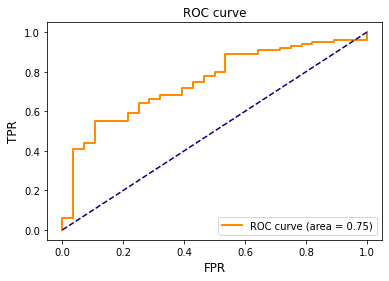

In [58]:
lw = 2
plt.plot(fpr, tpr,color='darkorange',lw=lw,label='ROC curve (area = %0.2f)'% roc_auc)
plt.xlabel('FPR',fontsize=12)
plt.ylabel('TPR',fontsize=12)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

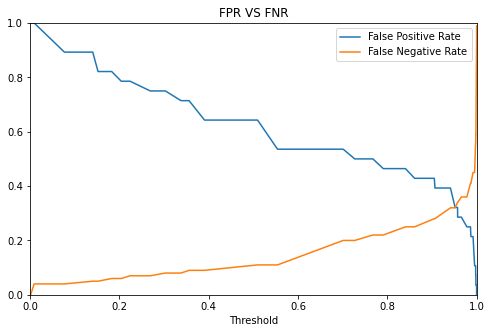

In [59]:
predtst=clf_ros.predict_proba(X_nd)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_nd, predtst)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(8,5))
# ax.plot([0.035,0.035],[0,0.1])
ax.set_xbound(0,1);
ax.set_ybound(0,1)
plt.title('FPR VS FNR')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [61]:
## X_only_num
predtst=clf_ros.predict_proba(X_nd)[:,1]## X_only_num
tuned_thresh = np.where(predtst > 0.95, 1, 0)
conf_matrix(y_nd, tuned_thresh).T

,True 1(Admitted),True 0(Denied)
Pred 1(Admitted as Admitted),TP = 68 (TPR = 68.00%),FP = 9 (FPR = 32.14%)
Pred 0(Denied as Denied),FN = 32 (FNR = 32.00%),TN = 19 (TNR = 67.86%)


In [181]:
#y_score=clf.predict_proba(X_test)
metrics.roc_auc_score(y_test, tuned_thresh)
fpr, tpr, _ = metrics.roc_curve(y_test, tuned_thresh,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
#return roc_auc,fpr,tpr

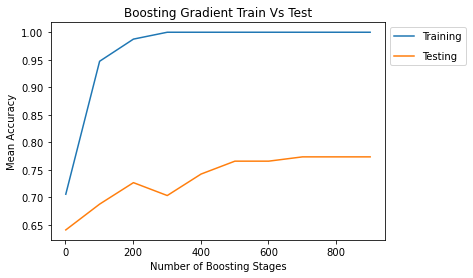

In [63]:
plt.plot(BGResult_ros['LevelLimit'],BGResult_ros['Score for Training'],label="Training")
plt.plot(BGResult_ros['LevelLimit'],BGResult_ros['Score for Testing'],label="Testing")
#plt.xticks(np.arange(0,100,10))
plt.legend(bbox_to_anchor=(1, 1),labelspacing=1)
plt.xlabel('Number of Boosting Stages')
plt.ylabel('Mean Accuracy')
plt.title('Boosting Gradient Train Vs Test')
plt.show()

# Appendix

In [110]:
prob_Den=list(clf_ros.predict_proba(X_nd)[:,0].round(2))
prob=list(clf_ros.predict_proba(X_nd)[:,1].round(2))

In [111]:
gb_ros=clf_ros.predict(X_nd)

In [112]:
p=pd.DataFrame(columns=['Admitted_Probabilty','Denied_Probability','Predicted_Decision','Decision'])

In [113]:
p['Admitted_Probabilty']=prob
p['Denied_Probability']=prob_Den
p['Predicted_Decision']=gb_ros
p['Decision']=y_nd

In [124]:
p[p.Decision==1].sort_values('Admitted_Probabilty')

,Admitted_Probabilty,Denied_Probability,Predicted_Decision,Decision
85,0.00,1.00,0,1
82,0.00,1.00,0,1
106,0.00,1.00,0,1
50,0.01,0.99,0,1
30,0.08,0.92,0,1
...,...,...,...,...
34,1.00,0.00,1,1
33,1.00,0.00,1,1
32,1.00,0.00,1,1
53,1.00,0.00,1,1
